# Results v8:

## General Hyperparameters:

- Dataset: MNIST (full-res 28x28px)
- Model: 2-layer MLP (784-64-ReLU-10) -> 50,890 parameters
- Training batch size: 32
- Optimizer: SGD
- Learning rate: 0.001
- L2 regularization: 0.001
- Epochs: 5

## Experiments:
- GGN eigenspace overlap (LOBPCG, 100 iterations)
- Laplace approximations (Hutchinson trace estimation, 5000 samples; CG inversion, 20 iterations; 100 test data points)

## Experiment Settings:
- GGN sample sizes: $[2^i]_{i=0}^{10}$, 60000 (full)
- Sampling methods: uniform, loss, loss-inv, loss-class, loss-class-inv, loss-classeq, loss-classeq-inv
- 5 re-runs for all experiments apart from Laplace approximations (as too expensive)

In [11]:
from pathlib import Path
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.ticker import LogFormatterExponent
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())

In [9]:
results_path = "../results_v8"
min_exp = 0
max_exp = 10
num_steps = 8000
sampling_methods = ["uniform", "loss", "loss_inv", "loss_class", "loss_class_inv", "loss_classeq", "loss_classeq_inv"]
run_indices = [idx for idx in range(1, 6)]
full_sample_size = 60000
laplace_samples = 100

sample_sizes = [2**x for x in range(min_exp, max_exp+1)]

sampling_method_combinations =[["uniform", "loss", "loss_inv"], ["uniform", "loss_class", "loss_class_inv"], ["uniform", "loss_classeq", "loss_classeq_inv"]]

## Experiment 1: Eigenspace Overlap

In [6]:
results = {}

for sampling_method in sampling_methods:
    results[sampling_method] = []
    for run_index in run_indices:
        results[sampling_method].append([])
        for sample_size in sample_sizes:
            results[sampling_method][-1].append(np.load(str(Path(results_path, sampling_method, "eigen", str(run_index), f"eigvecs_{sample_size}_{num_steps}.npy"))))
        results[sampling_method][-1] = np.nan_to_num(np.stack(results[sampling_method][-1]))
    results[sampling_method] = np.stack(results[sampling_method])
    # runs, sample_sizes, d, num_eigvecs

results_full = np.nan_to_num(np.stack([np.load(str(Path(results_path, "full", "eigen", str(run_index), f"eigvecs_{full_sample_size}_{num_steps}.npy")))]))

plot_data = {}
for sampling_method in sampling_methods:
    temp = np.einsum("ijklm,ijkln->ijkmn", results_full[:, None, None, :, :], results[sampling_method][None, :, :, :, :])  # runs1, runs2, sample_sizes, ne, ne
    temp = np.einsum("ijklm,ijknm->ijkln", temp, results[sampling_method][None, :, :, :, :])  # runs1, runs2, sample_sizes, ne, d
    temp = np.einsum("ijklm,ijkmn->ijkln", temp, results_full[:, None, None, :, :])  # runs1, runs2, sample_sizes, ne, ne
    temp = np.einsum("ijkll->ijk", temp)
    plot_data[sampling_method] = temp / np.sqrt(np.sum((results_full * results_full), axis=(-1, -2))[:, None, None] * np.sum((results[sampling_method] * results[sampling_method]), axis=(-1, -2))[None, :, :])
    plot_data[sampling_method] = np.reshape(plot_data[sampling_method], (-1, len(sample_sizes)))

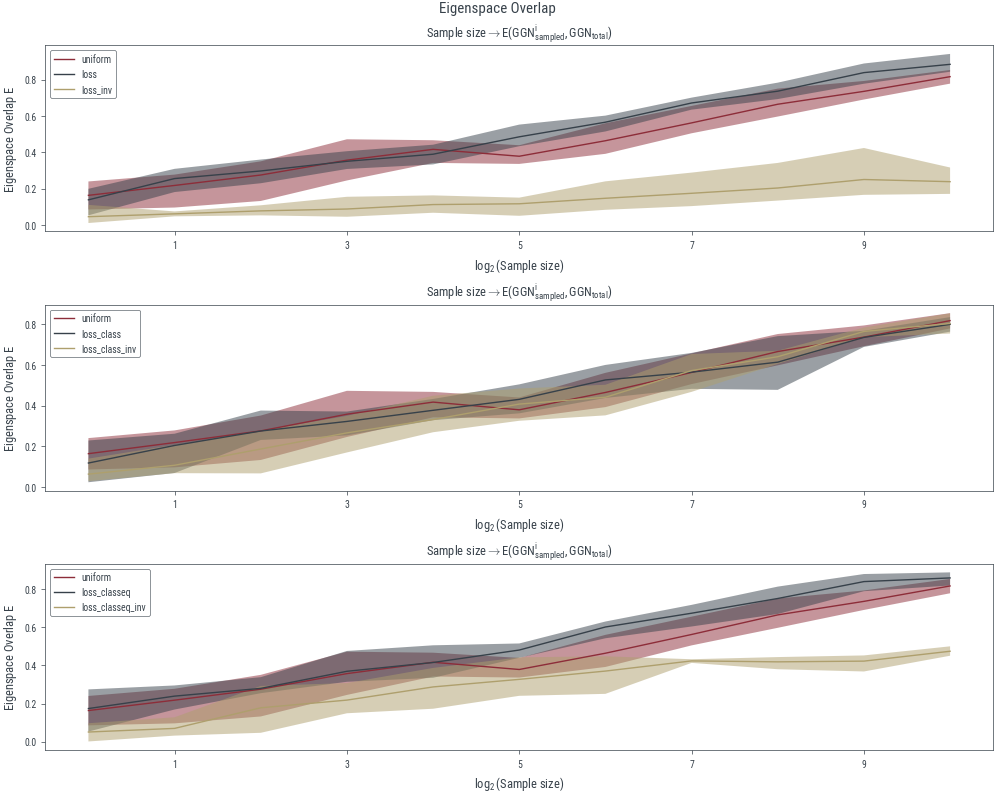

In [7]:
fig, axs = plt.subplots(len(sampling_method_combinations), figsize=(10, 8))
fig.suptitle("Eigenspace Overlap")

for idx, sampling_method_combination in enumerate(sampling_method_combinations):
    for sampling_method in sampling_method_combination:
        axs[idx].plot(sample_sizes, plot_data[sampling_method].mean(axis=0), label=sampling_method)
        axs[idx].fill_between(sample_sizes, np.min(plot_data[sampling_method], axis=0), np.max(plot_data[sampling_method], axis=0), alpha=0.5)
    axs[idx].set_title("$\\text{Sample size} \\to E(\\text{GGN}^{i}_{\\text{sampled}}, \\text{GGN}_{\\text{total}})$")
    axs[idx].set_xscale('log', base=2)
    axs[idx].set_xlabel("$\\log_2{(\\text{Sample size})}$")
    xlogfmt = LogFormatterExponent(base=2, labelOnlyBase=True)
    axs[idx].xaxis.set_major_formatter(xlogfmt)
    axs[idx].set_ylabel("$\\text{Eigenspace Overlap E}$")
    axs[idx].legend();

## Experiment 2: Laplace Approximation:

In [36]:
laplace_results = {}

for sampling_method in sampling_methods:
    laplace_results[sampling_method] = []
    for sample_size in sample_sizes:
        laplace_diagonals = np.nan_to_num(np.load(str(Path(results_path, sampling_method, "laplace", f"laplace_diagonal_{sample_size}_{num_steps}.npy"))))
        #laplace_diagonals = laplace_diagonals / np.sum(laplace_diagonals, axis=-1, keepdims=True)
        #laplace_logits = np.nan_to_num(np.load(str(Path(results_path, sampling_method, "laplace", f"laplace_logits_{sample_size}_{num_steps}.npy"))))
        #laplace_result = sp.special.softmax(laplace_logits / np.sqrt(1 + np.pi/8 * laplace_diagonals), axis=-1)
        laplace_result = laplace_diagonals
        laplace_results[sampling_method].append(laplace_result)
    laplace_results[sampling_method] = np.stack(laplace_results[sampling_method])[:, :laplace_samples]

laplace_diagonals_full = np.nan_to_num(np.load(str(Path(results_path, "full", "laplace", f"laplace_diagonal_{full_sample_size}_{num_steps}.npy"))))[:laplace_samples]
# laplace_diagonals_full = laplace_diagonals_full / np.sum(laplace_diagonals_full, axis=-1, keepdims=True)
# laplace_logits_full = np.nan_to_num(np.load(str(Path(results_path, "full", "laplace", f"laplace_logits_{full_sample_size}_{num_steps}.npy"))))[:laplace_samples]
# laplace_result_full = sp.special.softmax(laplace_logits_full / np.sqrt(1 + np.pi/8 * laplace_diagonals_full), axis=-1)
laplace_result_full = laplace_diagonals_full

In [38]:
for sampling_method in sampling_methods:
    laplace_logits = np.nan_to_num(np.load(str(Path(results_path, sampling_method, "laplace", f"laplace_logits_1_{num_steps}.npy"))))
    print(np.argmax(laplace_logits))

laplace_logits_full = np.nan_to_num(np.load(str(Path(results_path, "full", "laplace", f"laplace_logits_60000_{num_steps}.npy"))))[:laplace_samples]
print(np.argmax(laplace_logits_full))

[4 1 7 2 1 5 0 9 5 9 9 3 4 3 3 1 4 5 6 0 9 0 5 5 8 2 2 4 4 7 1 7 0 8 6 4 5
 8 3 8 4 9 4 1 2 6 7 2 0 7 9 0 2 2 3 3 7 3 6 4 1 2 6 0 0 1 7 5 9 0 3 5 7 4
 3 3 8 6 9 7 2 7 6 2 1 0 5 9 2 3 0 3 2 3 2 8 2 0 8 9 3 1 9 4 1 7 2 3 9 7 9
 1 4 1 1 9 9 5 9 1 4 8 8 7 3 1 9 0 1 8 8 1 3 2 4 8 8 6 2 5 1 8 4 8 6 6 9 1
 0 3 6 3 1 5 5 2 4 0 4 0 8 7 2 4 3 9 0 8 7 0 9 3 2 5 6 2 2 4 0 7 9 0 4 2 8
 0 8 9 1 7 5 7 2 7 8 0 6 7 4 9]
[5 5 2 7 8 6 0 2 8 5 5 8 7 2 8 4 8 7 7 9 4 2 2 8 4 2 7 3 9 1 2 1 0 2 4 8 1
 2 4 6 7 6 9 5 1 9 0 6 2 9 9 4 9 4 1 3 4 3 5 5 4 3 1 0 7 3 7 9 0 5 2 3 3 3
 6 1 2 6 3 5 5 6 3 4 1 3 4 0 9 0 8 7 8 9 6 3 2 7 7 1 5 1 1 3 7 4 4 6 4 3 1
 8 0 5 7 9 4 5 1 1 9 3 7 5 8 0 1 8 4 3 9 7 7 3 9 7 9 2 2 3 8 5 2 9 5 0 1 0
 0 7 0 3 4 3 6 2 4 8 0 7 3 1 1 7 0 0 9 4 5 2 6 8 1 5 9 1 7 3 7 3 6 2 3 0 3
 2 1 1 3 9 8 2 6 6 9 1 1 1 9 0]
[5 5 2 7 8 6 0 2 8 5 5 8 7 2 8 4 8 7 7 9 4 2 2 8 4 2 7 3 9 1 2 1 0 2 4 8 1
 2 4 6 7 6 9 5 1 9 0 6 2 9 9 4 9 4 1 3 4 3 5 5 4 3 1 0 7 3 7 9 0 5 2 3 3 3
 6 1 2 6 3 5 5 6 3 4 1 3 4 0 9 0 8 7

### Visual comparison with examples:

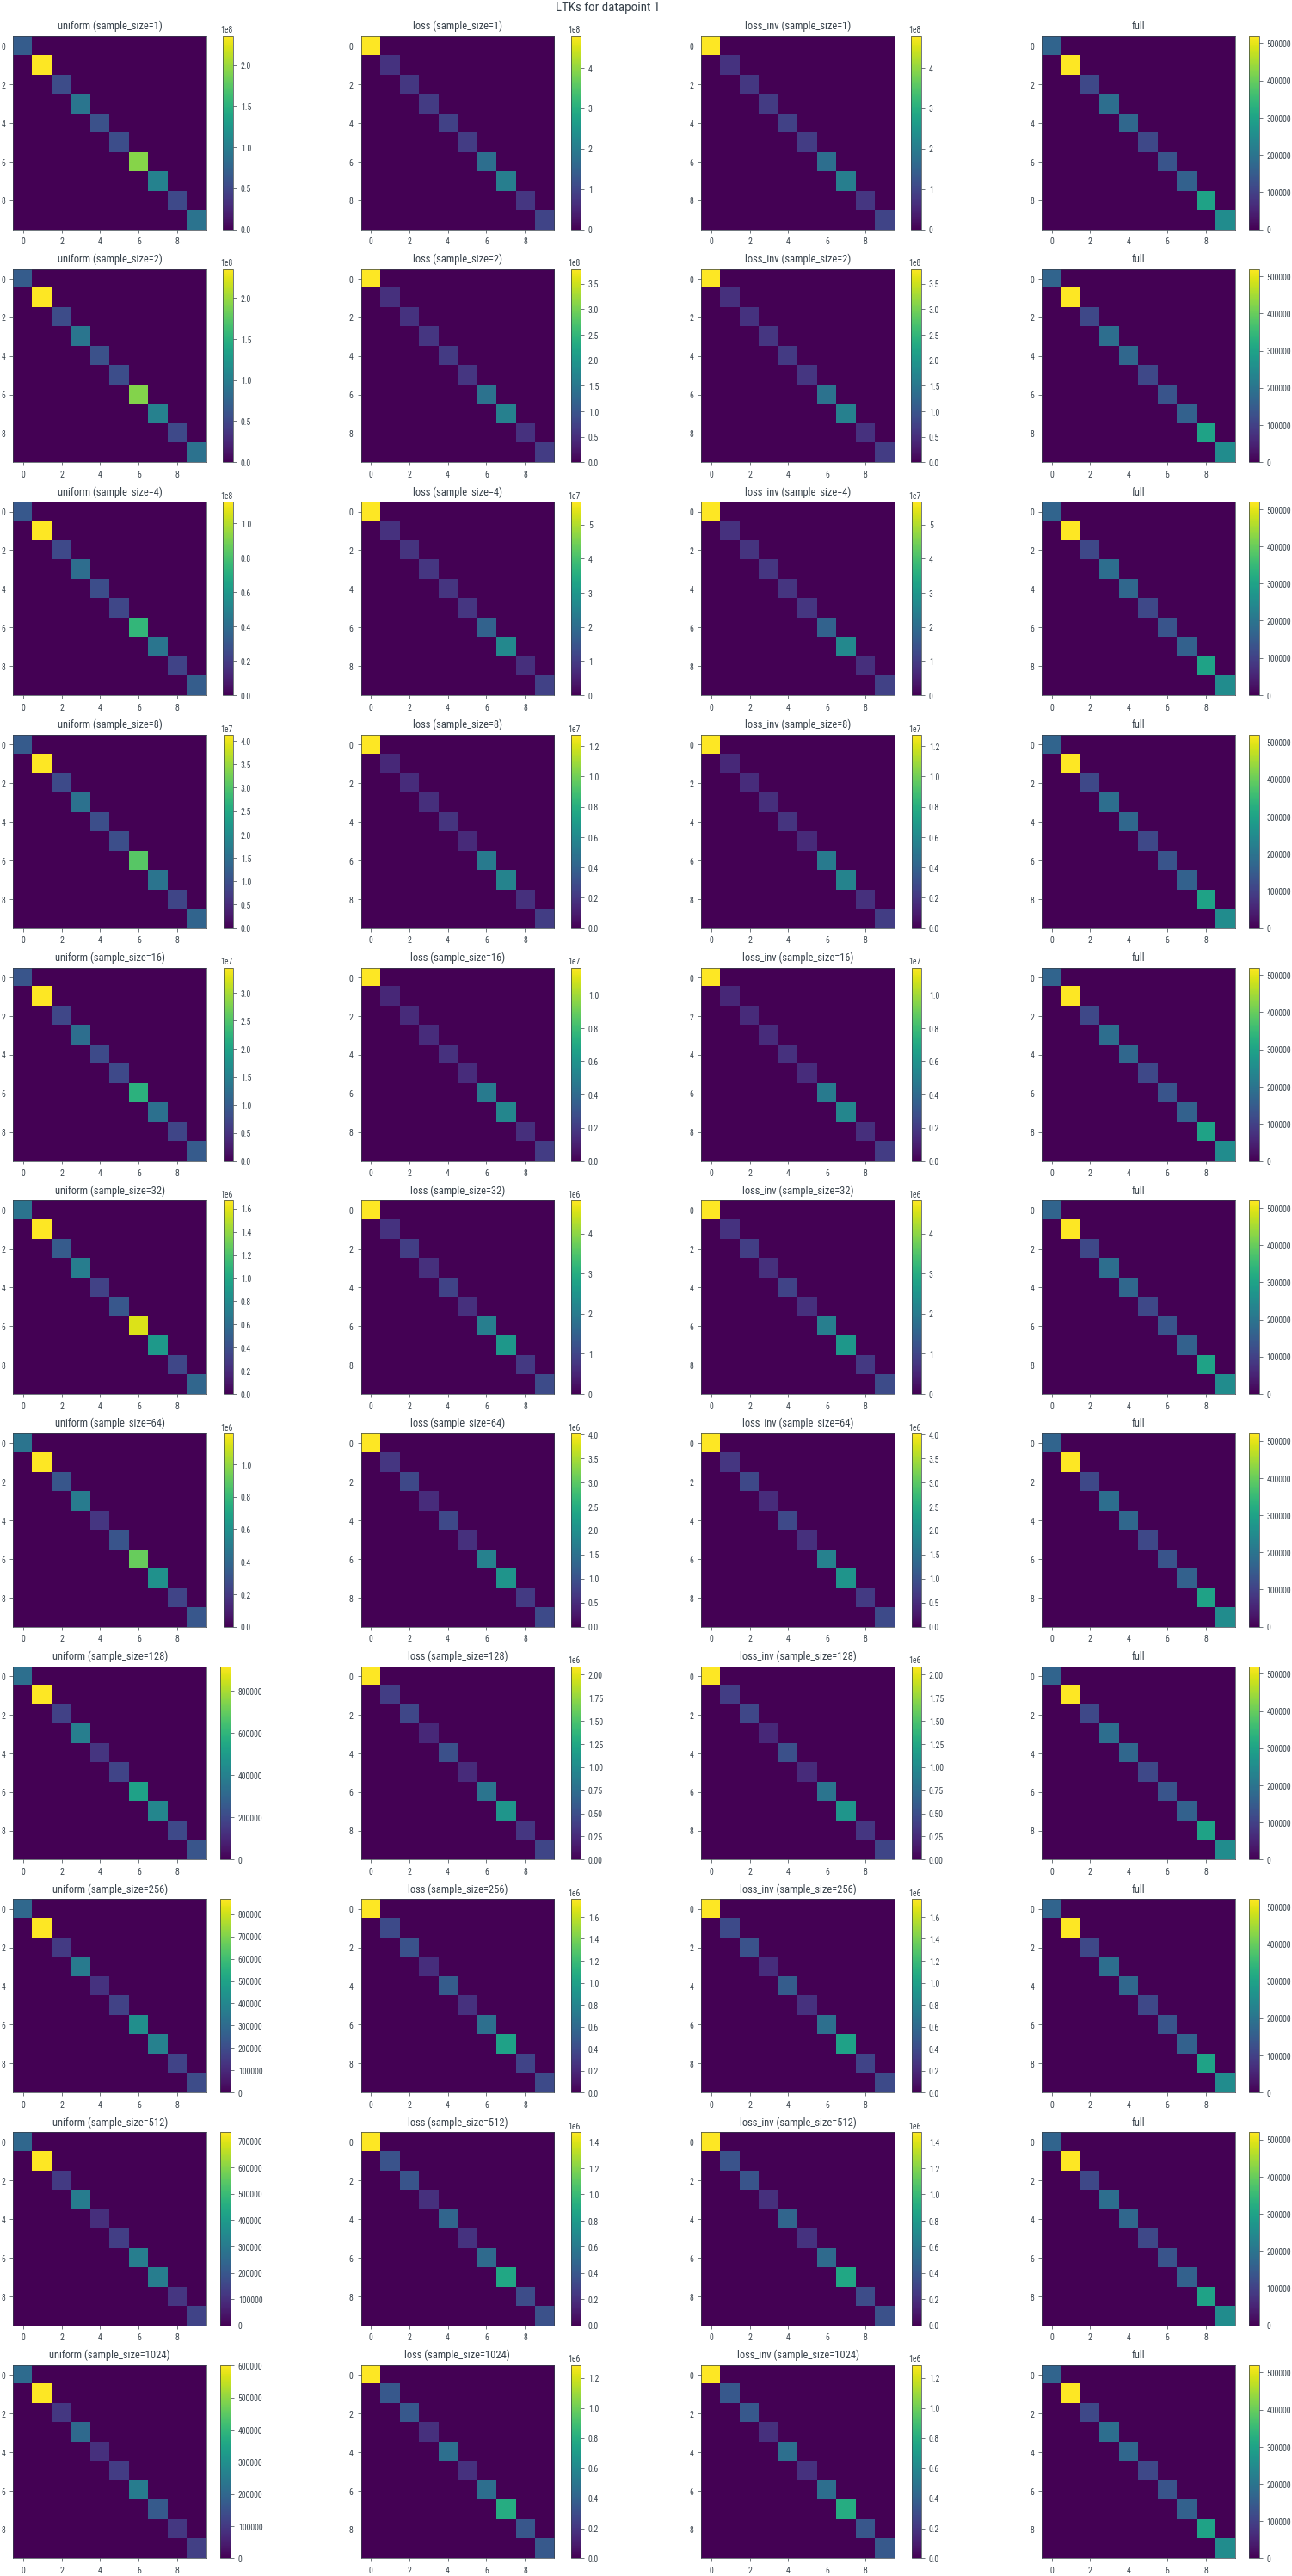

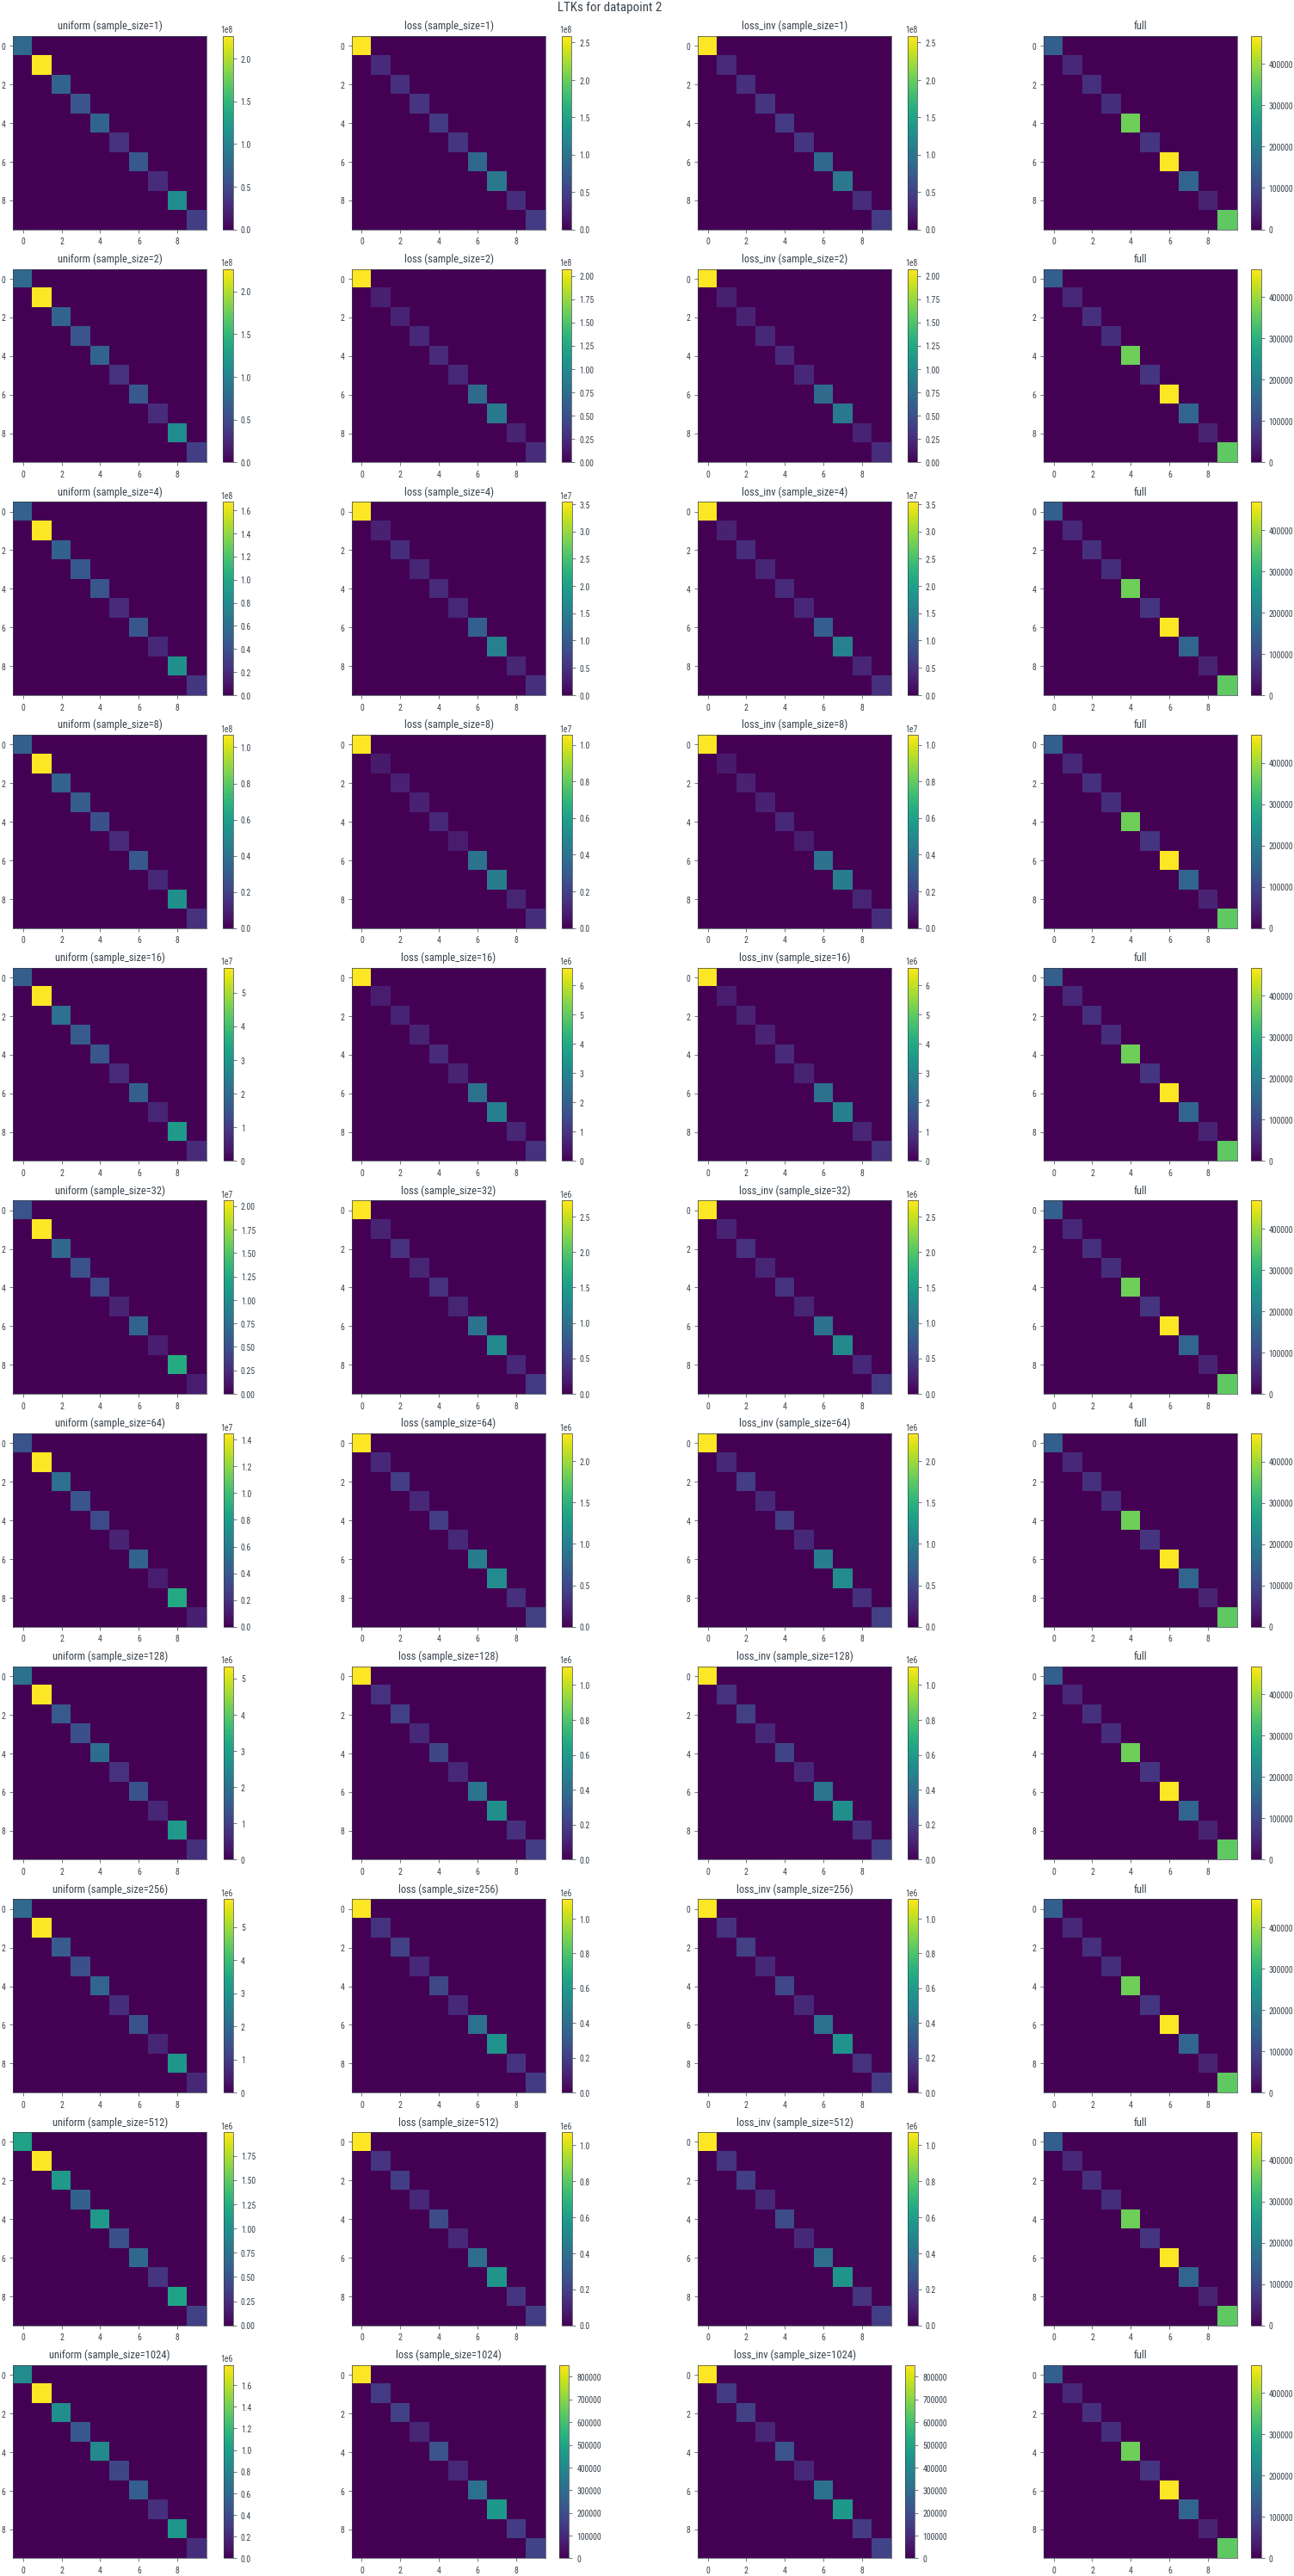

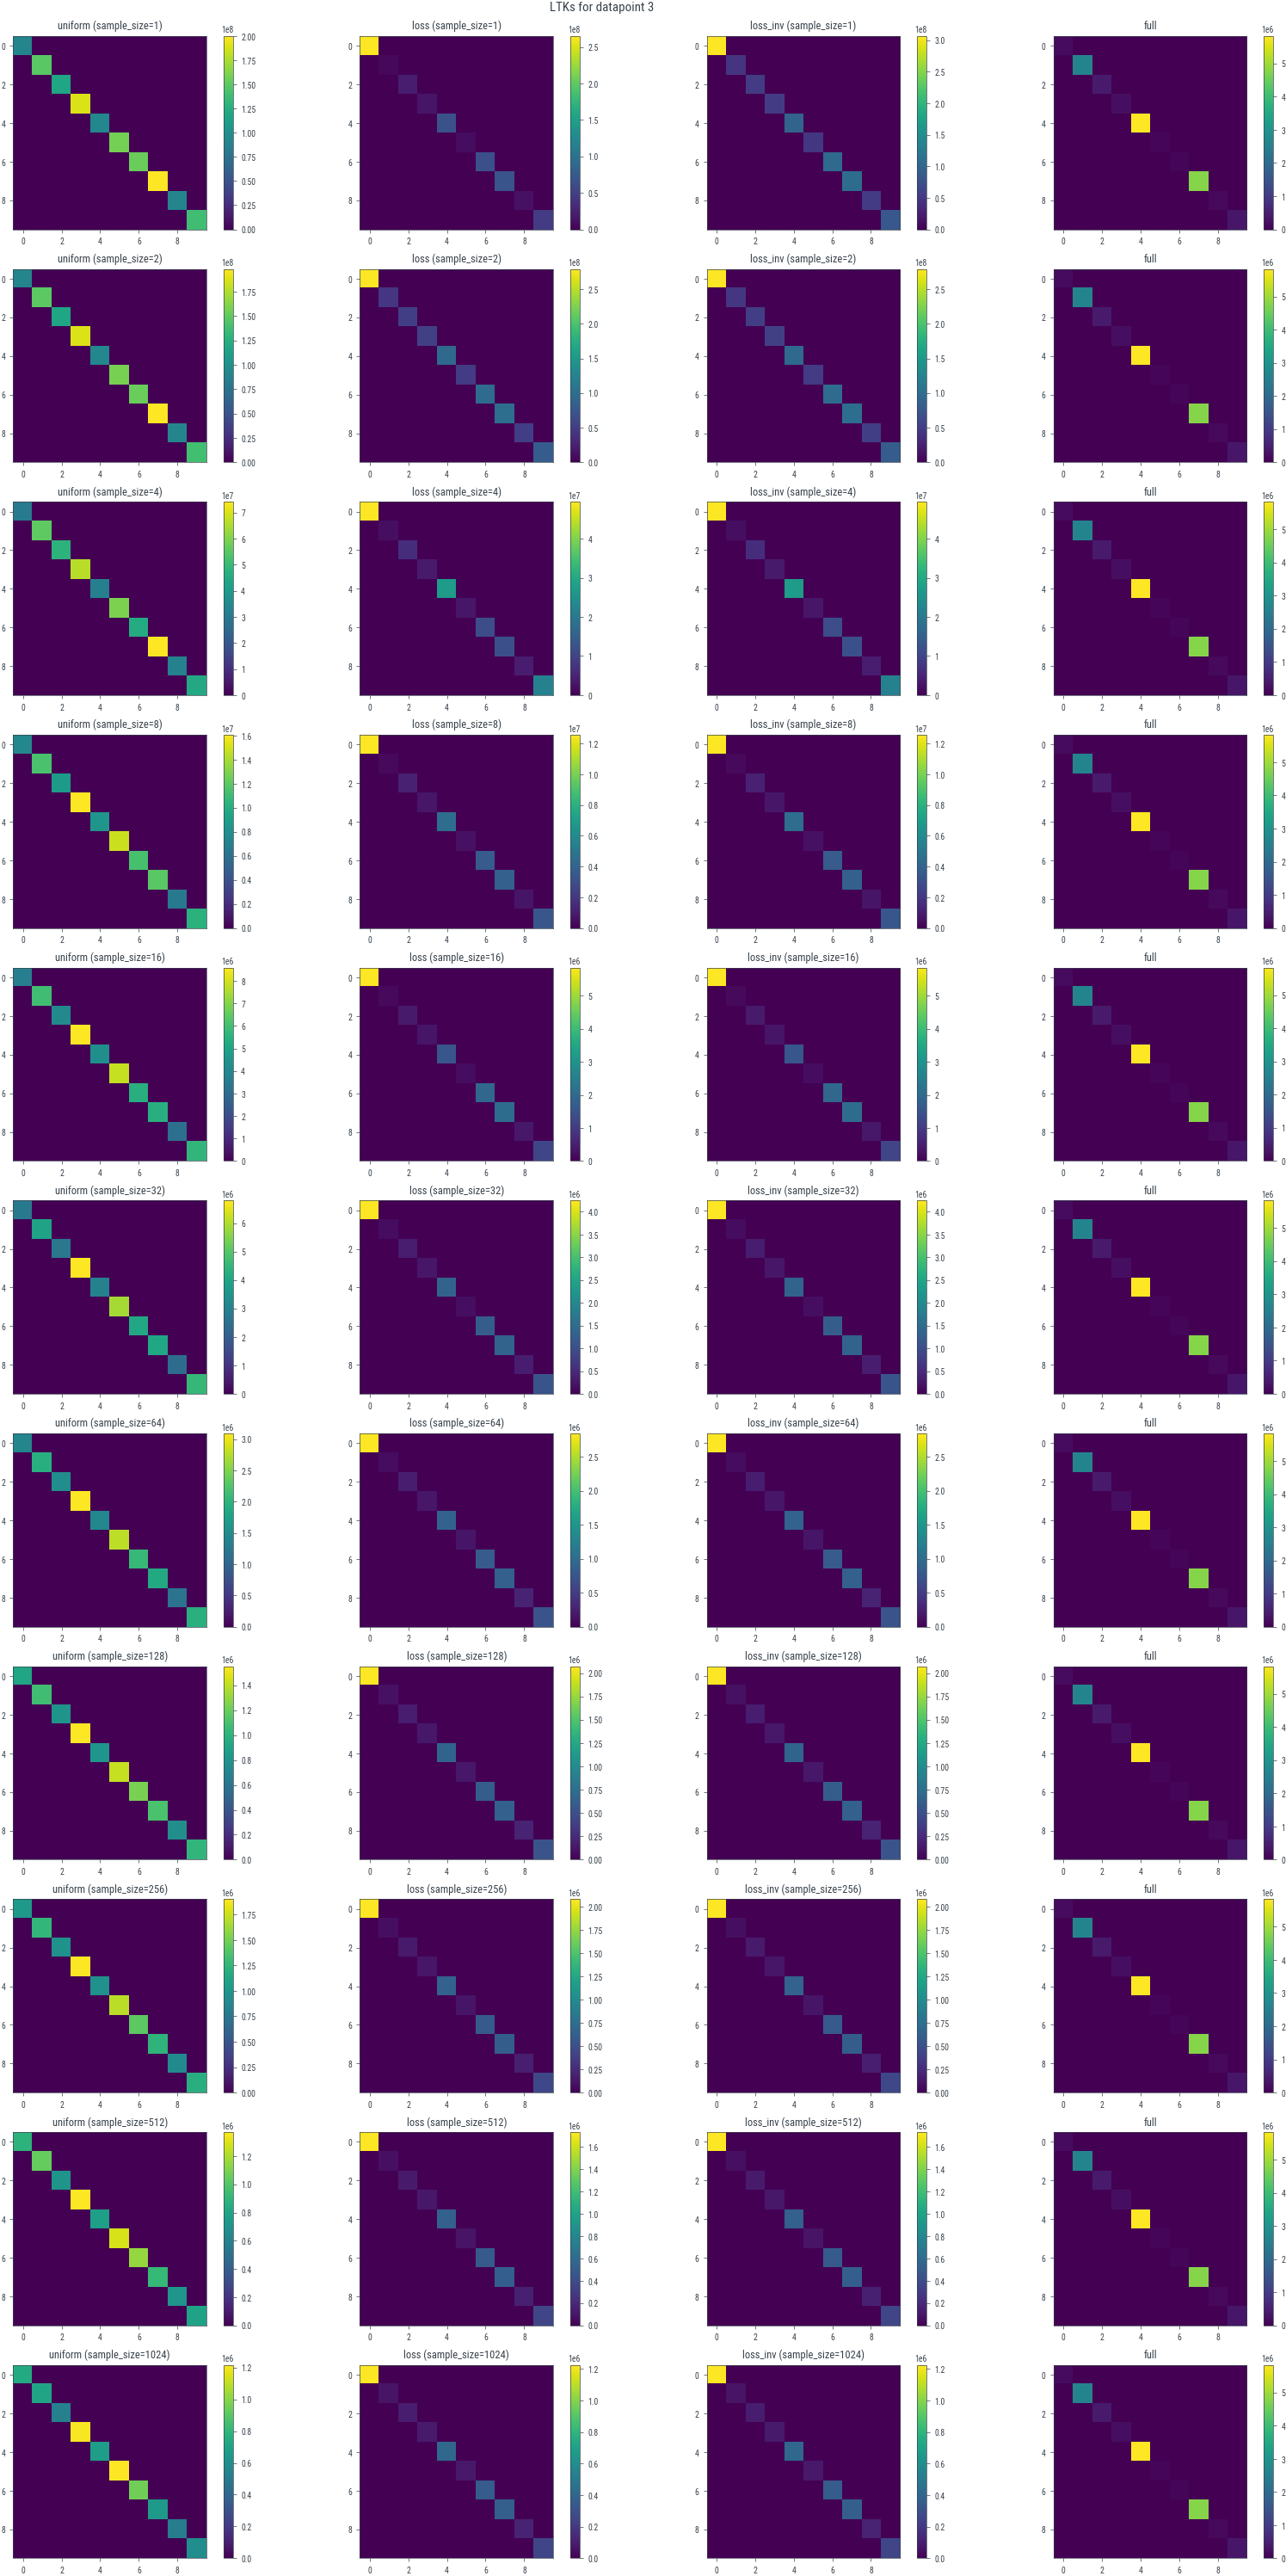

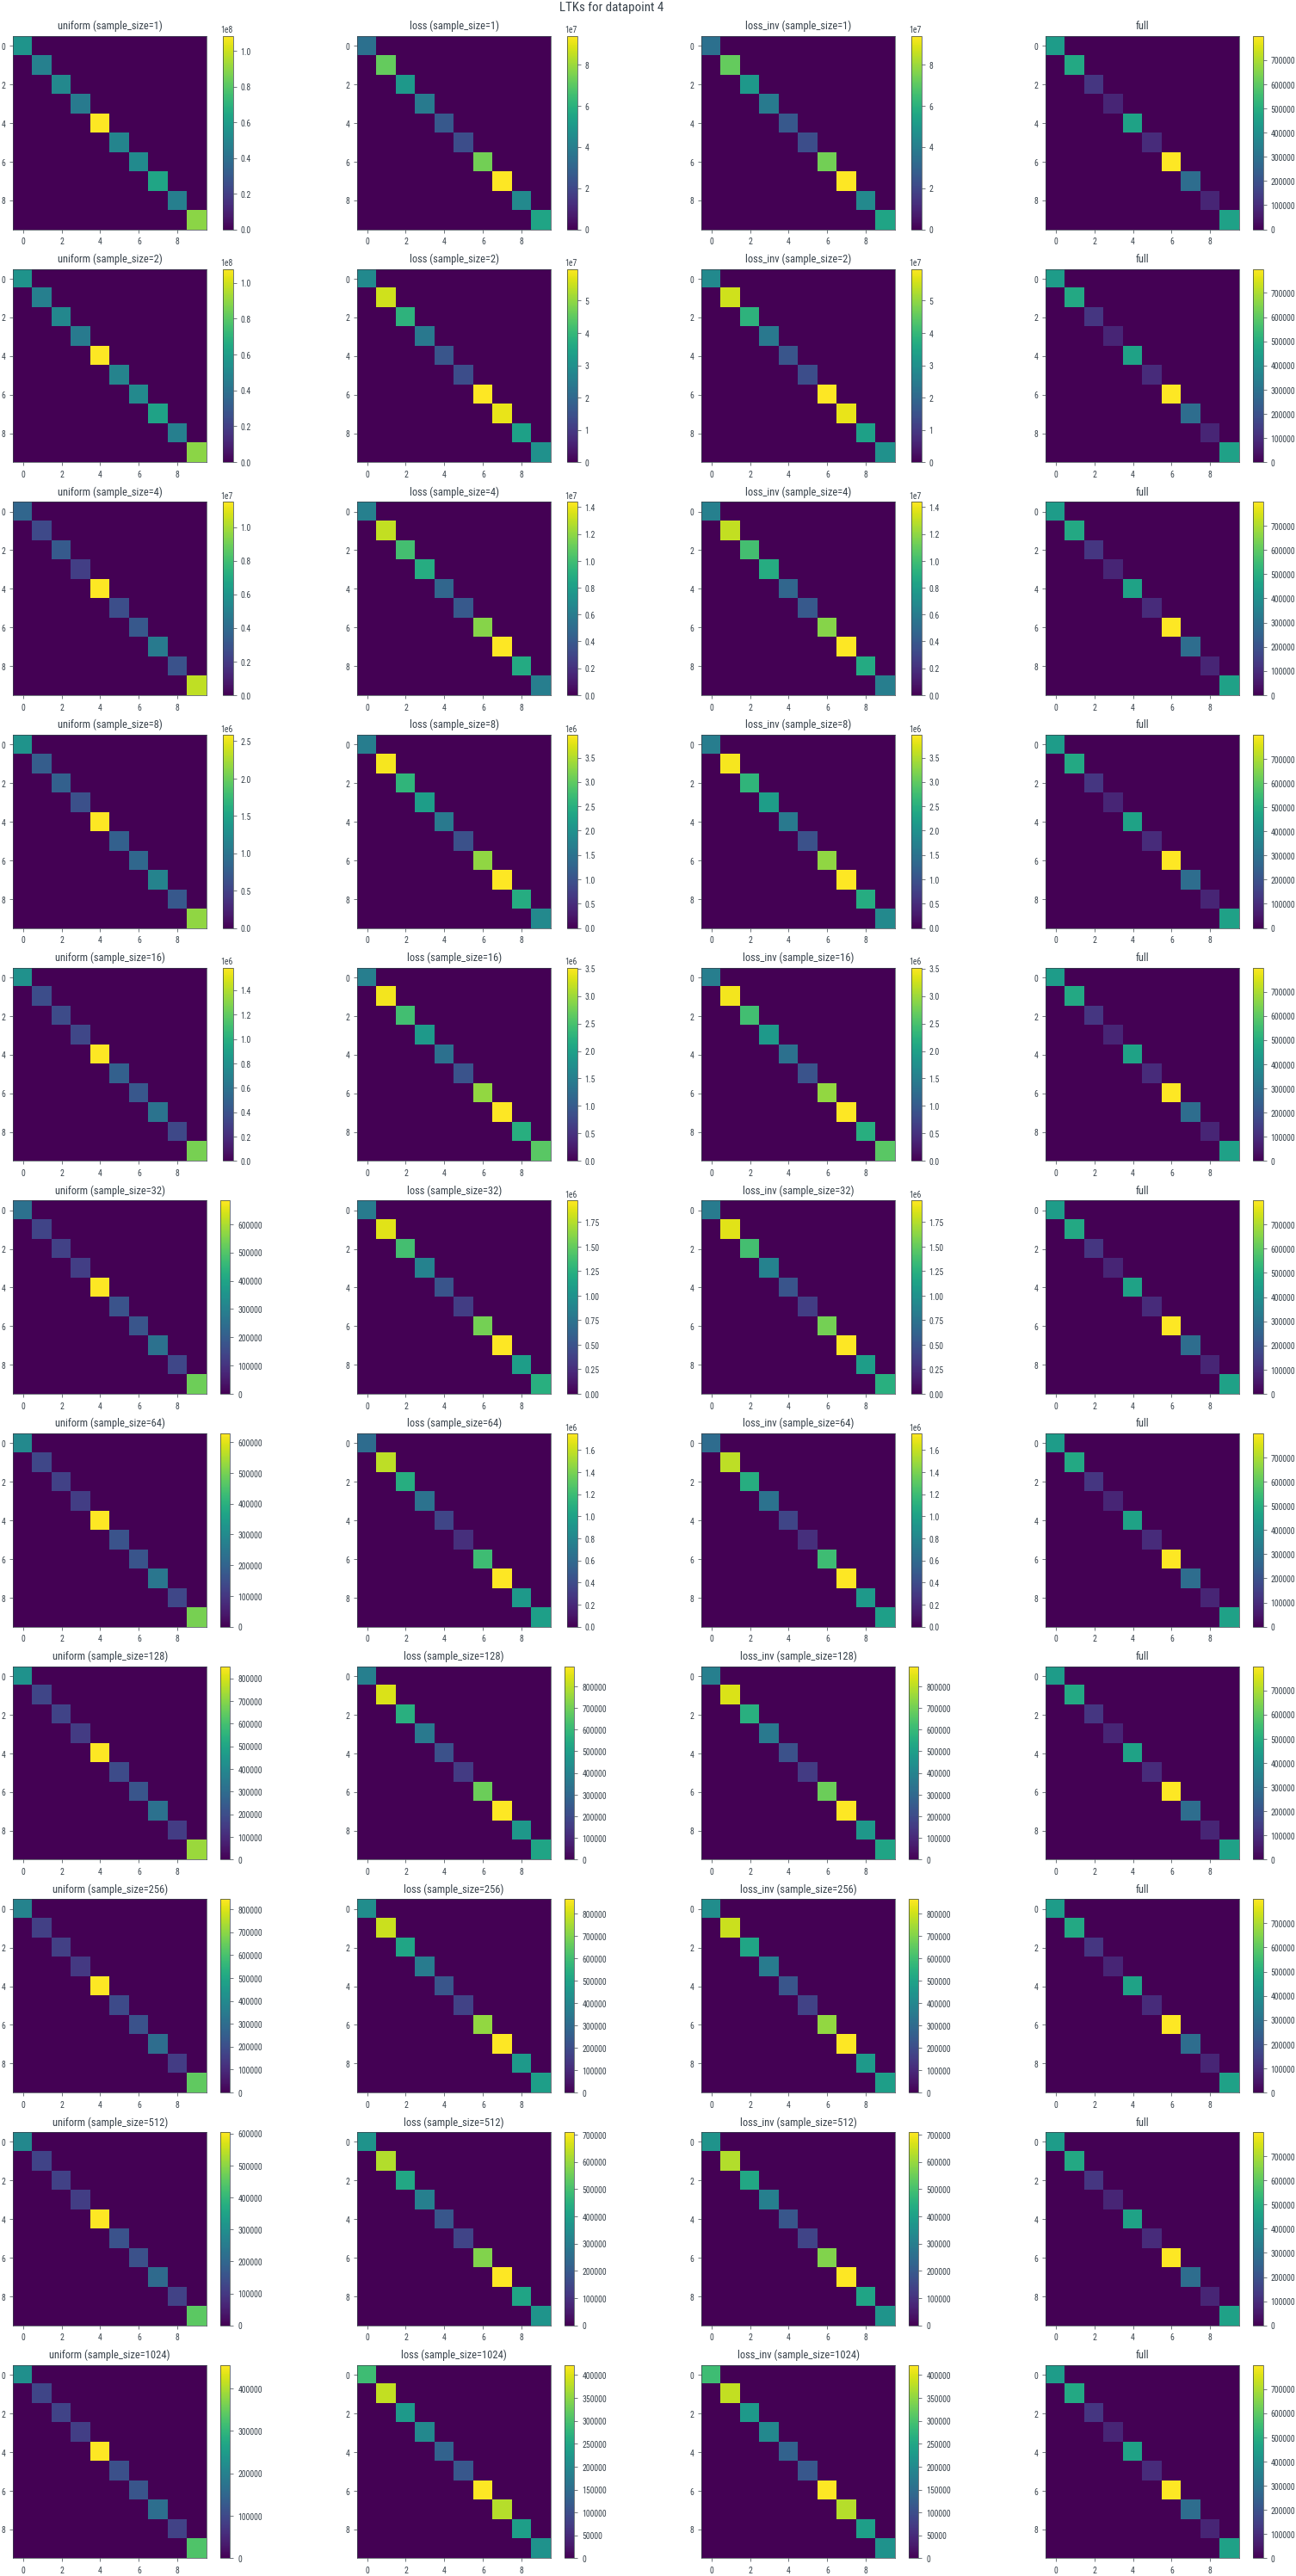

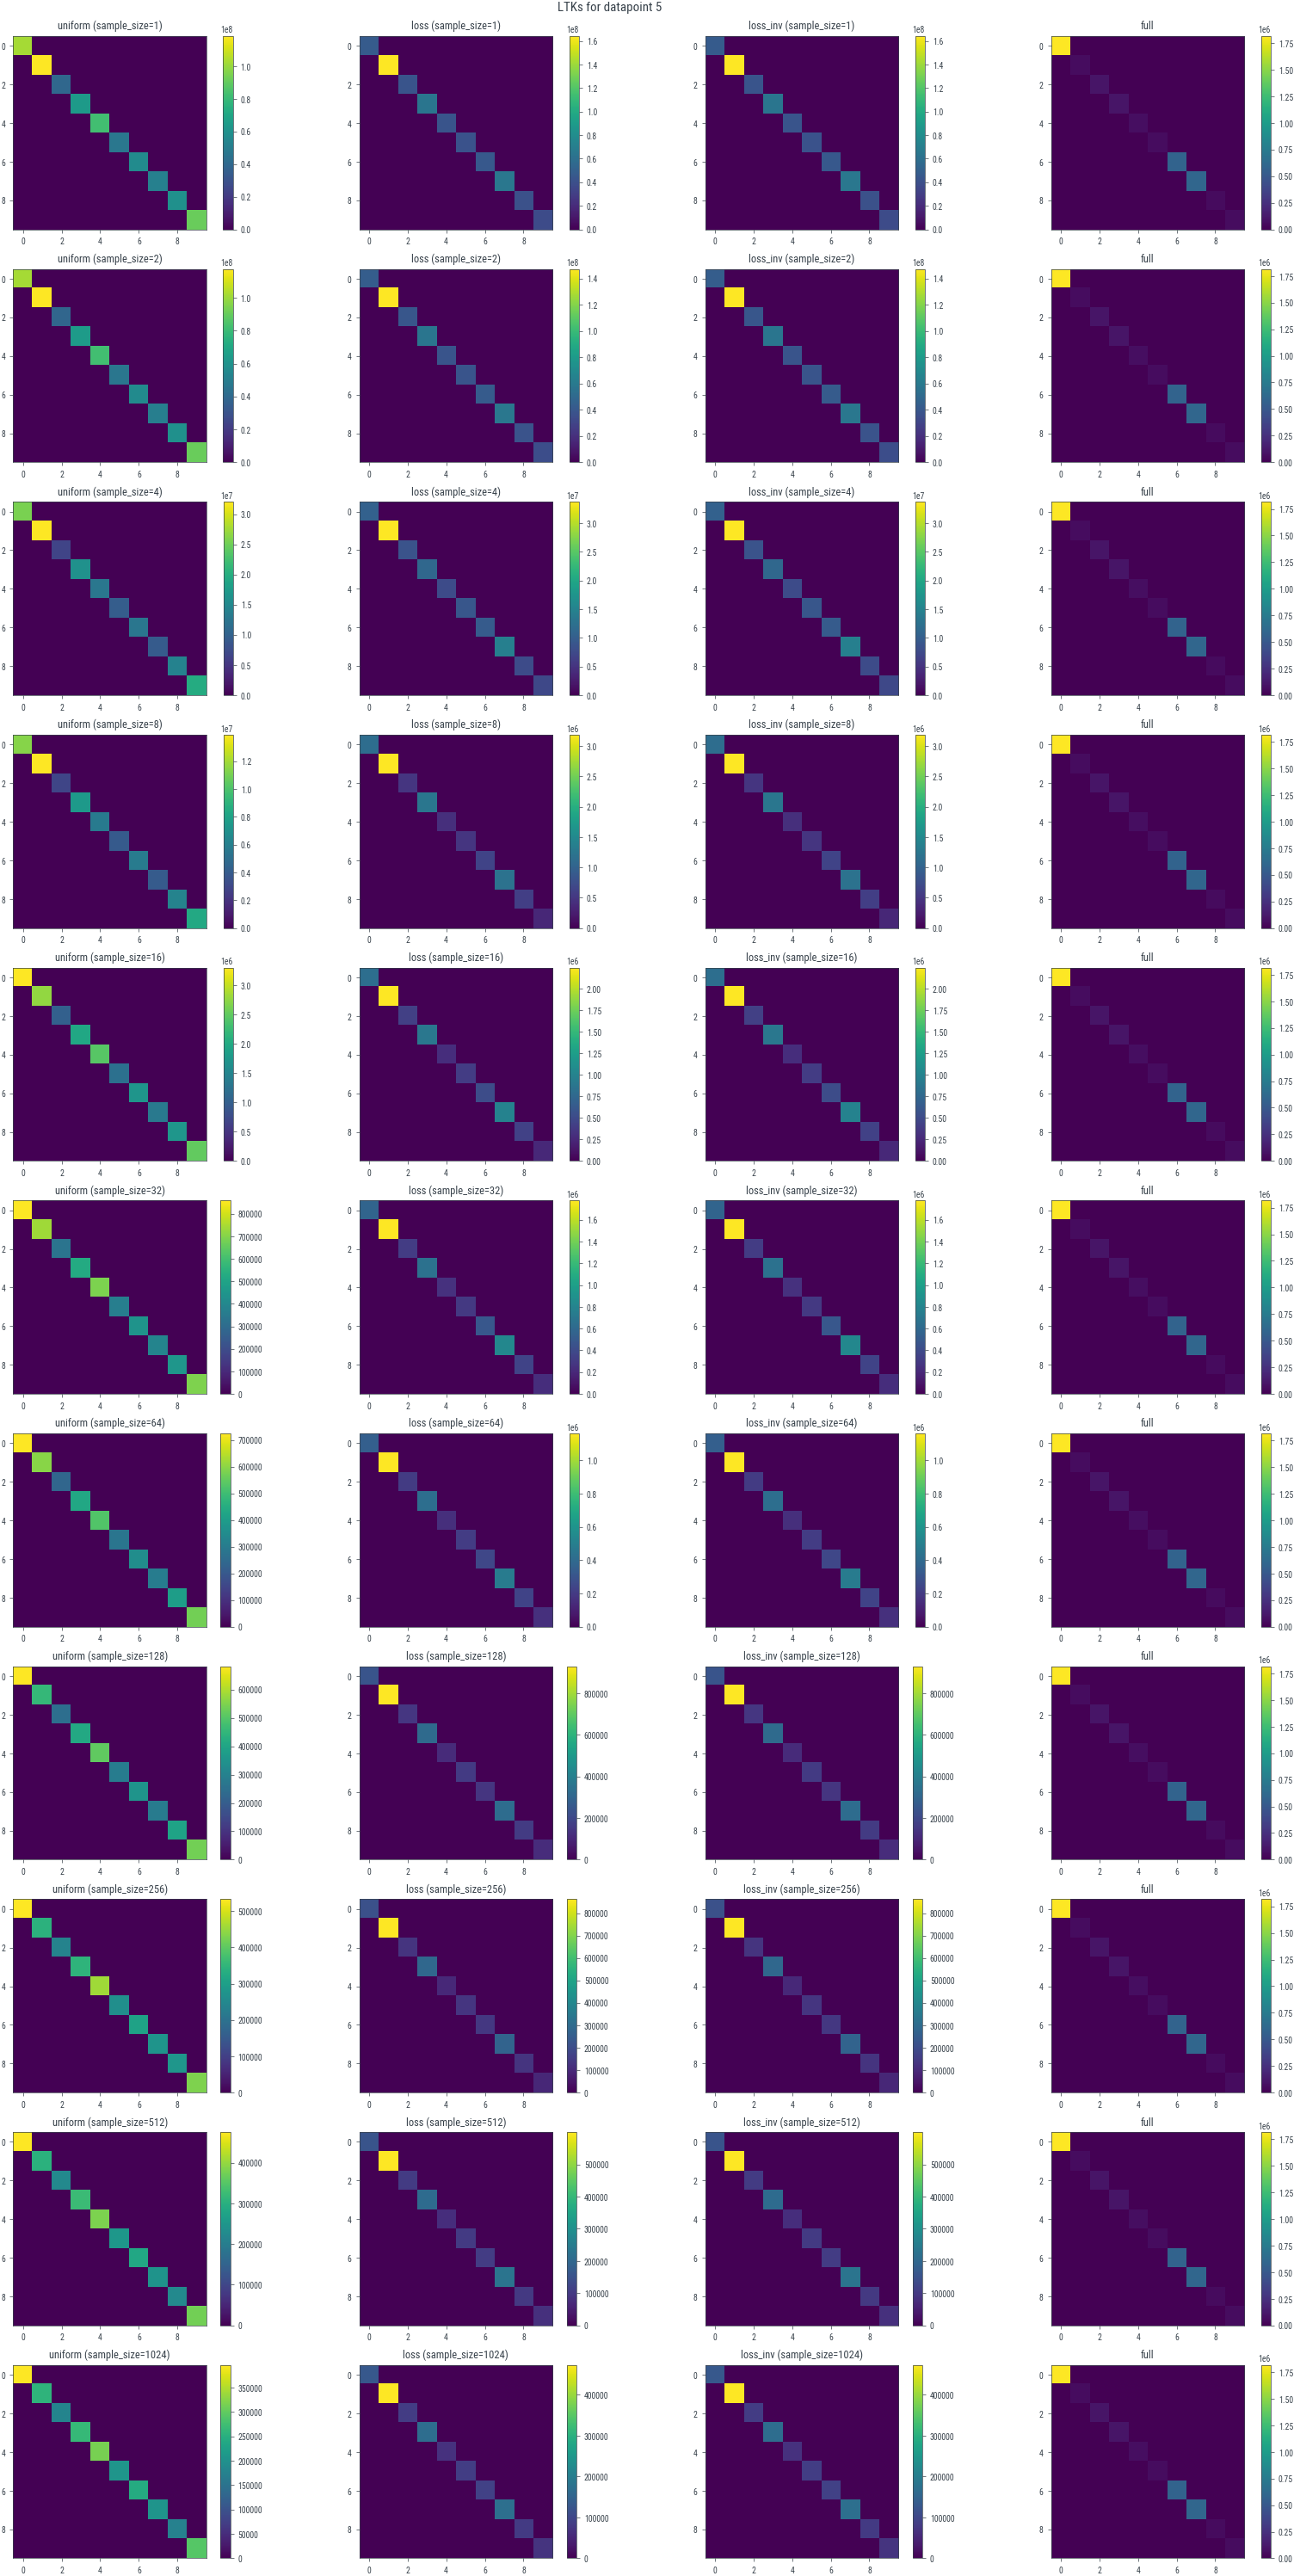

In [37]:
for test_sample_idx in range(5):
    fig, axs = plt.subplots(len(sample_sizes), len(sampling_method_combinations[0]) + 1, figsize=(16, 30))

    for samples_idx, sample_size in enumerate(sample_sizes):
        for method_idx, sampling_method in enumerate(sampling_method_combinations[0]):
            ltk_diag = np.diag(laplace_results[sampling_method][samples_idx, test_sample_idx])
            p = axs[samples_idx, method_idx].imshow(ltk_diag)
            fig.colorbar(p)
            axs[samples_idx, method_idx].set_title(f"{sampling_method} (sample_size={sample_size})")
        
        ltk_diag = np.diag(laplace_result_full[test_sample_idx])
        p = axs[samples_idx, len(sampling_method_combinations[0])].imshow(ltk_diag)
        fig.colorbar(p)
        axs[samples_idx, len(sampling_method_combinations[0])].set_title(f"full")     
    
    plt.suptitle(f"LTKs for datapoint {test_sample_idx + 1}")
    plt.show();